In [1]:
# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install networkx
    !pip install lovely-tensors

Installing PyTorch Geometric


Installing other libraries


In [1]:
# Import python modules

import sys
import random
import numpy as np

from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Linear, TransformerEncoder, TransformerEncoderLayer, LayerNorm, Module, ModuleList

import torch_geometric
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_batch, to_dense_adj

import lovely_tensors as lt
lt.monkey_patch()

from torch.optim import Adam

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.4.0


In [5]:
#@title [RUN] Import python modules

import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp
from scipy.stats import ortho_group
from scipy.linalg import block_diag

import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, Module, ModuleList, Sequential

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.datasets import Planetoid, QM9
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

# from google.colab import files
from IPython.display import HTML

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

/tmp/ipykernel_2829945/3034156839.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.4.0


In [6]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [7]:
#@title [RUN] Helper functions for unit testing

################################
# Dummy data helpers for Part 1
################################

def get_dummy_data_transductive():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[0.1680148244],
        [0.3310719728],
        [0.2041909844],
        [0.2041909844]])
    return A, x, y

def get_dummy_data_inductive_layer():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[0.1086086035],
        [0.1543375552],
        [0.1992474943],
        [0.1992474943]])
    return A, x, y

def get_dummy_data_inductive_model():
    input_dim = 64
    A = torch.tensor([[0, 1, 1, 0],
        [1, 0, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]])
    x = torch.rand(A.shape[0], input_dim)
    y = torch.tensor([[-0.0814725384]])
    return A, x, y

################################
# Dummy data helpers for Part 2
################################

def get_dummy_data():
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [0, 0, 1]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [0, 0, 2]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )
    yield Batch(
        x=torch.Tensor([[1], [1]]),
        pos=torch.Tensor([[0, 0, 0], [1, 2, 3]]),
        edge_index=torch.LongTensor([[0, 1], [1, 0]]),
        edge_attr=torch.Tensor([[1], [1]]),
    )


# Invariant Dummies
def dummy_not_invariant(x, pos, edge_index, edge_attr):
    return pos

def dummy_invariant(x, pos, edge_index, edge_attr):
    return x

def dummy_only_trans_invariant(x, pos, edge_index, edge_attr):
    return pos - torch.unsqueeze(pos[0], dim=0)

def dummy_only_rot_invariant(x, pos, edge_index, edge_attr):
    return torch.sum(pos * torch.unsqueeze(pos[0], dim=0), dim=-1)


# Equivariant Dummies
def dummy_equivariant(x, pos, edge_index, edge_attr):
    return x, pos

def dummy_not_equivariant(x, pos, edge_index, edge_attr):
    return pos, 2 * pos + 2

def dummy_h_not_invariant(x, pos, edge_index, edge_attr):
    return pos, pos

def dummy_x_not_equivariant(x, pos, edge_index, edge_attr):
    return x, 2 * pos + 2

def dummy_h_only_trans_invariant(x, pos, edge_index, edge_attr):
    return dummy_only_trans_invariant(x, pos, edge_index, edge_attr), pos

def dummy_h_only_rot_invariant(x, pos, edge_index, edge_attr):
    return dummy_only_rot_invariant(x, pos, edge_index, edge_attr), pos

def dummy_x_only_trans_equivariant(x, pos, edge_index, edge_attr):
    return x, pos + 2

def dummy_x_only_rot_equivariant(x, pos, edge_index, edge_attr):
    return x, 2 * pos

In [8]:
# @title [RUN] Helper functions for managing experiments, training, and evaluating models

def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None, special_color=False):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)


def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()


def hash_node_embedings(node_emb):
  """ Hash the tensor representing nodes' features
  to a number in [0,1] used to represent a color

  Args:
    node_emb: list of num_graphs arrays, each of dim (num_nodes x num_feats)
  Returns:
    list of num_graphs arrays in [0,1], each of dim (num_nodes)
  """
  chunk_size_graph = [x.shape[0] for x in node_emb]
  start_idx_graph = [0] + list(itertools.accumulate(chunk_size_graph))[:-1]

  node_emb_flatten = np.concatenate(node_emb).mean(-1)

  min_emb = node_emb_flatten.min()
  max_emb = node_emb_flatten.max()
  node_emb_flatten = (node_emb_flatten-min_emb)/(max_emb-min_emb)

  #split in graphs again according to (start_idx_graph, chunk_size_graph)
  node_emb_hashed = [node_emb_flatten[i:i+l] for (i,l) in zip(start_idx_graph, chunk_size_graph)]
  return node_emb_hashed


def update_stats(training_stats, epoch_stats):
    """ Store metrics along the training
    Args:
      epoch_stats: dict containg metrics about one epoch
      training_stats: dict containing lists of metrics along training
    Returns:
      updated training_stats
    """
    if training_stats is None:
        training_stats = {}
        for key in epoch_stats.keys():
            training_stats[key] = []
    for key,val in epoch_stats.items():
        training_stats[key].append(val)
    return training_stats


def plot_stats(training_stats, figsize=(5, 5), name=""):
    """ Create one plot for each metric stored in training_stats
    """
    stats_names = [key[6:] for key in training_stats.keys() if key.startswith('train_')]
    f, ax = plt.subplots(len(stats_names), 1, figsize=figsize)
    if len(stats_names)==1:
        ax = np.array([ax])
    for key, axx in zip(stats_names, ax.reshape(-1,)):
        axx.plot(
            training_stats['epoch'],
            training_stats[f'train_{key}'],
            label=f"Training {key}")
        axx.plot(
            training_stats['epoch'],
            training_stats[f'val_{key}'],
            label=f"Validation {key}")
        axx.set_xlabel("Training epoch")
        axx.set_ylabel(key)
        axx.legend()
    plt.title(name)


def get_color_coded_str(i, color):
    return "\033[3{}m{}\033[0m".format(int(color), int(i))


def print_color_numpy(map, list_graphs):
    """ print matrix map in color according to list_graphs
    """
    list_blocks = []
    for i,graph in enumerate(list_graphs):
        block_i = (i+1)*np.ones((graph.num_nodes,graph.num_nodes))
        list_blocks += [block_i]
    block_color = block_diag(*list_blocks)

    map_modified = np.vectorize(get_color_coded_str)(map, block_color)
    print("\n".join([" ".join(["{}"]*map.shape[0])]*map.shape[1]).format(*[x for y in map_modified.tolist() for x in y]))

print("Helper functions loaded.")


def train_gnn_cora(X, y, mask, model, optimiser):
    model.train()
    optimiser.zero_grad()
    y_hat = model(X)[mask]
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimiser.step()
    return loss.data


def evaluate_gnn_cora(X, y, mask, model):
    model.eval()
    y_hat = model(X)[mask]
    y_hat = y_hat.data.max(1)[1]
    num_correct = y_hat.eq(y.data).sum()
    num_total = len(y)
    accuracy = 100.0 * (num_correct/num_total)
    return accuracy


# Training loop
def train_eval_loop_gnn_cora(model, train_x, train_y, train_mask,
                        valid_x, valid_y, valid_mask,
                        test_x, test_y, test_mask
                    ):
    optimiser = Adam(model.parameters(), lr=LR)
    training_stats = None
    # Training loop
    for epoch in range(NUM_EPOCHS):
        train_loss = train_gnn_cora(train_x, train_y, train_mask, model, optimiser)
        train_acc = evaluate_gnn_cora(train_x, train_y, train_mask, model)
        valid_acc = evaluate_gnn_cora(valid_x, valid_y, valid_mask, model)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} with train loss: {train_loss:.3f} train accuracy: {train_acc:.3f} validation accuracy: {valid_acc:.3f}")
        # store the loss and the accuracy for the final plot
        epoch_stats = {'train_acc': train_acc, 'val_acc': valid_acc, 'epoch':epoch}
        training_stats = update_stats(training_stats, epoch_stats)
    # Lets look at our final test performance
    test_acc = evaluate_gnn_cora(test_x, test_y, test_mask, model)
    print(f"Our final test accuracy for the SimpleGNN is: {test_acc:.3f}")
    return training_stats

Helper functions loaded.


In [9]:
# @title [RUN] `CoraDataset` implementation
# Let's get the Planetoid Cora dataset from
# “FastGCN: Fast Learning with Graph Convolutional
# Networks via Importance Sampling” (https://arxiv.org/abs/1801.10247)

from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj

class CoraDataset(object):
    def __init__(self):
        super(CoraDataset, self).__init__()
        cora_pyg = Planetoid(root='/tmp/Cora', name='Cora', split="full")
        self.cora_data = cora_pyg[0]
        self.train_mask = self.cora_data.train_mask
        self.valid_mask = self.cora_data.val_mask
        self.test_mask = self.cora_data.test_mask

    def train_val_test_split(self):
        train_x = self.cora_data.x[self.cora_data.train_mask]
        train_y = self.cora_data.y[self.cora_data.train_mask]

        valid_x = self.cora_data.x[self.cora_data.val_mask]
        valid_y = self.cora_data.y[self.cora_data.val_mask]

        test_x = self.cora_data.x[self.cora_data.test_mask]
        test_y = self.cora_data.y[self.cora_data.test_mask]
        return train_x, train_y, valid_x, valid_y, test_x, test_y

    def get_fullx(self):
        return self.cora_data.x

    def get_adjacency_matrix(self):
        # We will ignore this for the first part
        adj = to_dense_adj(self.cora_data.edge_index)[0]
        return adj

In [10]:
# Lets download our cora dataset and get the splits
cora_data = CoraDataset()
train_x, train_y, valid_x, valid_y, test_x, test_y = cora_data.train_val_test_split()

# Always check and confirm our data shapes match our expectations
print(f"Train shape x: {train_x.shape}, y: {train_y.shape}")
print(f"Val shape x: {valid_x.shape}, y: {valid_y.shape}")
print(f"Test shape x: {test_x.shape}, y: {test_y.shape}")

Train shape x: torch.Size([1208, 1433]), y: torch.Size([1208])
Val shape x: torch.Size([500, 1433]), y: torch.Size([500])
Test shape x: torch.Size([1000, 1433]), y: torch.Size([1000])


In [11]:
# Fill in the initialisation and forward method the GCNLayer below

class GCNLayer(Module):
    """Graph Convolutional Network layer from Kipf & Welling.

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(GCNLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # ============ YOUR CODE HERE ==============
        self.A_hat = A + torch.eye(A.size(0))                                 # A + I
        D_hat = torch.diag(torch.pow(self.A_hat.sum(1), -0.5))                # D^(-1/2)
        self.adj_norm = torch.matmul(torch.matmul(D_hat, self.A_hat), D_hat)  # D^(-1/2) A D^(-1/2)
        self.linear = Linear(input_dim, output_dim)                           # W
        # ===========================================

    def forward(self, x):
        """Implements the forward pass for the layer

        Args:
            x (torch.Tensor): input node feature matrix
        """
        # ============ YOUR CODE HERE ==============
        print(x)
        x = torch.matmul(self.adj_norm, x)  # Aggregate neighbor information
        x = self.linear(x)  # Apply linear transformation W
        x = F.relu(x)  # Apply non-linearity
        # ===========================================
        return x

In [12]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
def testing_gcn():
  torch.random.manual_seed(0)
  np.random.seed(0)
  A,x,y = get_dummy_data_transductive()

  input_dim = x.shape[-1]
  output_dim = y.shape[-1]

  torch.random.manual_seed(0)
  model = GCNLayer(input_dim, output_dim, A)
  out = model(x)

  assert(out.shape == (A.shape[0], output_dim)), "Oops! 🤭 Output shape is wrong"

  perm = np.random.permutation(x.shape[0])
  perm_x = x[perm]
  perm_out = out[perm]
  A_perm = A[perm, :][:, perm]

  torch.random.manual_seed(0)
  model_perm = GCNLayer(input_dim, output_dim, A_perm)

  out_model_perm = model_perm(perm_x)
  assert (torch.allclose(perm_out, out_model_perm, atol=1e-6)), "🤔 Something is wrong in the model! The output is not permutation equivariant anymore 🥺"

  assert (torch.allclose(out, y, atol=1e-6)), "🤔 Something is wrong in the model! The output is wrong."
  print("✅ All seems good!!!")


# run unit test function
testing_gcn()

tensor[4, 64] n=256 (1Kb) x∈[0.001, 0.997] μ=0.477 σ=0.285
tensor[4, 64] n=256 (1Kb) x∈[0.001, 0.997] μ=0.477 σ=0.285
✅ All seems good!!!


In [13]:
# Lets see the GCNLayer in action!

class SimpleGNN(Module):
    """A Simple GNN model using the GCNLayer for node classification

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_gcn_layers, A):
        super(SimpleGNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # Note: if a single layer is used hidden_dim should be the same as input_dim
        if num_gcn_layers > 1:
          self.gcn_layers = [GCNLayer(input_dim, hidden_dim, A)]
          self.gcn_layers += [GCNLayer(hidden_dim, hidden_dim, A) for i in range(num_gcn_layers-2)]
          self.gcn_layers += [GCNLayer(hidden_dim, output_dim, A)]
        else:
          self.gcn_layers = [GCNLayer(input_dim, output_dim, A)]

        self.gcn_layers = ModuleList(self.gcn_layers)
        self.num_gcn_layers = num_gcn_layers

    def forward(self, x):
        """Forward pass through SimpleGNN on input x

        Args:
            x (torch.Tensor): input node features
        """
        for j in range(self.num_gcn_layers-1):
          x = self.gcn_layers[j](x)
          x = F.relu(x)

        x = self.gcn_layers[-1](x)

        y_hat = x
        return y_hat

In [14]:
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

In [15]:
# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN(input_dim=train_x.shape[-1], output_dim=7, A=A, hidden_dim=train_x.shape[-1], num_gcn_layers=1)
train_mask = cora_data.train_mask
valid_mask = cora_data.valid_mask
test_mask = cora_data.test_mask

# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
Epoch 0 with train loss: 1.943 train accuracy: 26.325 validation accuracy: 29.200
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=0.112
tensor[2708, 1433] n=3880564 (15Mb) x∈[0., 1.000] μ=0.013 σ=

KeyboardInterrupt: 

In [14]:
# Fill in the initialisation and forward method the GCNLayer below

class GCNLayer_Transformer(Module):
    """Graph Convolutional Network layer from Kipf & Welling.

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, output_dim, A):
        super(GCNLayer_Transformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # ============ YOUR CODE HERE ==============
        self.multihead_attn = torch.nn.MultiheadAttention(input_dim, 1)
        self.linear = Linear(input_dim, output_dim)
        # ===========================================

    def forward(self, x):
        """Implements the forward pass for the layer

        Args:
            x (torch.Tensor): input node feature matrix
        """
        # ============ YOUR CODE HERE ==============
        x = self.multihead_attn(x, x, x)[0]
        # x = self.transformer_encoder(x, A)
        x = self.linear(x)
        # x = F.relu(x)
        # ===========================================
        return x

In [15]:
# @title ✅ [RUN] **Please run this unit test to validate your code. The output would be used to mark your practical.**
def testing_gcn():
  torch.random.manual_seed(0)
  np.random.seed(0)
  A,x,y = get_dummy_data_transductive()

  input_dim = x.shape[-1]
  output_dim = y.shape[-1]

  torch.random.manual_seed(0)
  model = GCNLayer_Transformer(input_dim, output_dim, A)
  out = model(x)

  assert(out.shape == (A.shape[0], output_dim)), "Oops! 🤭 Output shape is wrong"

  perm = np.random.permutation(x.shape[0])
  perm_x = x[perm]
  perm_out = out[perm]
  A_perm = A[perm, :][:, perm]

  torch.random.manual_seed(0)
  model_perm = GCNLayer_Transformer(input_dim, output_dim, A_perm)

  out_model_perm = model_perm(perm_x)
  assert (torch.allclose(perm_out, out_model_perm, atol=1e-6)), "🤔 Something is wrong in the model! The output is not permutation equivariant anymore 🥺"

  assert (torch.allclose(out, y, atol=1e-6)), "🤔 Something is wrong in the model! The output is wrong."
  print("✅ All seems good!!!")

# run unit test function
testing_gcn()

AssertionError: 🤔 Something is wrong in the model! The output is wrong.

In [16]:
# Lets see the GCNLayer in action!

class SimpleGNN_Transformer(Module):
    """A Simple GNN model using the GCNLayer for node classification

    Args:
        input_dim (int): Dimensionality of the input feature vectors
        output_dim (int): Dimensionality of the output softmax distribution
        A (torch.Tensor): 2-D adjacency matrix
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_gcn_layers, A):
        super(SimpleGNN_Transformer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A = A

        # Note: if a single layer is used hidden_dim should be the same as input_dim
        if num_gcn_layers > 1:
          self.gcn_layers = [GCNLayer_Transformer(input_dim, hidden_dim, A)]
          self.gcn_layers += [GCNLayer_Transformer(hidden_dim, hidden_dim, A) for i in range(num_gcn_layers-2)]
          self.gcn_layers += [GCNLayer_Transformer(hidden_dim, output_dim, A)]
        else:
          self.gcn_layers = [GCNLayer_Transformer(input_dim, output_dim, A)]

        self.gcn_layers = ModuleList(self.gcn_layers)
        self.num_gcn_layers = num_gcn_layers

    def forward(self, x):
        """Forward pass through SimpleGNN on input x

        Args:
            x (torch.Tensor): input node features
        """
        for j in range(self.num_gcn_layers-1):
          x = self.gcn_layers[j](x)
          x = F.relu(x)
          

        x = self.gcn_layers[-1](x)

        y_hat = x
        return y_hat

In [17]:
NUM_EPOCHS =  100 #@param {type:"integer"}
LR         = 0.001 #@param {type:"number"}

Epoch 0 with train loss: 1.946 train accuracy: 28.228 validation accuracy: 31.600
Epoch 10 with train loss: 1.841 train accuracy: 28.228 validation accuracy: 31.600
Epoch 20 with train loss: 1.735 train accuracy: 28.974 validation accuracy: 31.600
Epoch 30 with train loss: 1.300 train accuracy: 46.772 validation accuracy: 37.000
Epoch 40 with train loss: 1.023 train accuracy: 55.795 validation accuracy: 37.800
Epoch 50 with train loss: 0.785 train accuracy: 68.626 validation accuracy: 35.800
Epoch 60 with train loss: 0.539 train accuracy: 82.781 validation accuracy: 34.200
Epoch 70 with train loss: 0.311 train accuracy: 89.735 validation accuracy: 33.200
Epoch 80 with train loss: 0.136 train accuracy: 96.275 validation accuracy: 35.600
Epoch 90 with train loss: 0.048 train accuracy: 99.255 validation accuracy: 35.600
Our final test accuracy for the SimpleGNN is: 40.000


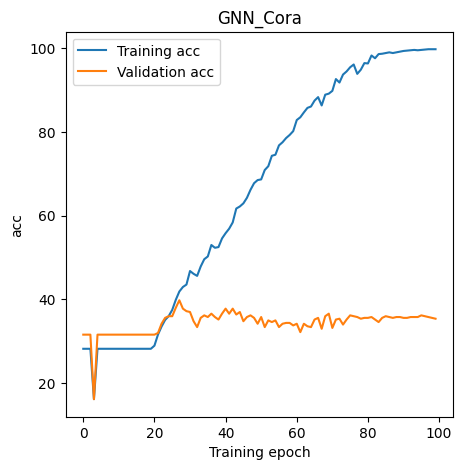

In [18]:
# Instantiate our model and optimiser
A = cora_data.get_adjacency_matrix()
X = cora_data.get_fullx()
model = SimpleGNN_Transformer(input_dim=train_x.shape[-1], output_dim=7, A=A, hidden_dim=train_x.shape[-1], num_gcn_layers=1)
train_mask = cora_data.train_mask
valid_mask = cora_data.valid_mask
test_mask = cora_data.test_mask

# Run training loop
train_stats_gnn_cora = train_eval_loop_gnn_cora(model, X, train_y, train_mask,
                                          X, valid_y, valid_mask,
                                          X, test_y, test_mask
                                       )
plot_stats(train_stats_gnn_cora, name="GNN_Cora")

In [ ]:
# hetrophilic task -> attending to everythig is better
# homophilic task -> attending to graph is good

# dont use cora !! --- highly homophilic
# control homophily

# cyclic object

# get some results - do not fail the project
# logit you can fit the forward pass and


# if you want to switch from inductive and transductive
# only modify the loss and not the forward pass

# start with inductive.
# contibue with transductive.


# Use CLRS
# --> NAR dataset
# --> graph trnsformers


# how well GNNs deal with over squashing?



# 1. homophilly in the ocntext of transformer and GNN

# Graph former
